<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Time Series - EDA</p>

# <p style="font-size:100%; text-align:left; color:#444444;">Table of Contents:</p>
* [1. EDA](#1)
  * [1.1 Rentals Data - Moby Bikes](#1.1)
  * [1.2 Weather Data - Met Éireann](#1.2)
  * [1.3 Unusual Observations analysis](#1.2)
* [2. Discrete Analysis (Count Data)](#2)
  * [2.1 Overdispersion](#2.1)
  * [2.2 Zero-inflated](#2.2)
* [2. Probability distribution vs Time Series](#2)
  * [2.1 Time series analysis](#2.1)
  * [2.2 Zero-inflated analysis](#2.2)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import scipy.stats as stats
from patsy import dmatrices

# statsmodels
from statsmodels.stats import diagnostic as diag
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
%reload_ext watermark
%watermark -a "Leandro Pessini" -n -u -v -iv -w

Author: Leandro Pessini

Last updated: Sun May 08 2022

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.3.0

matplotlib : 3.4.2
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
scipy      : 1.8.0
numpy      : 1.21.1
seaborn    : 0.11.1
statsmodels: 0.13.2
pandas     : 1.3.0

Watermark: 2.3.0



In [3]:
hourly_data = pd.read_csv('../data/processed/hourly_data.csv')
hourly_rentals = pd.read_csv('../data/processed/hourly_rentals.csv')
all_data = pd.read_csv('../data/processed/all_data.csv')
rentals = pd.read_csv('../data/interim/new_features_rentals.csv')
hourly_data.head()

,rain,temp,rhum,wdsp,date,hour,day,month,year,holiday,...,season,peak,timesofday,rainfall_intensity,wind_bft,wind_speed_group,temp_r,temp_bin,rhum_bin,count
0,0.0,0.1,98,4,2021-03-01,0,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,0,0.0,4.0,0
1,0.0,-1.1,98,3,2021-03-01,1,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,-1,0.0,4.0,0
2,0.0,-1.2,98,4,2021-03-01,2,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,-1,0.0,4.0,1
3,0.0,-0.9,100,5,2021-03-01,3,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,-1,0.0,4.0,0
4,0.0,0.0,100,6,2021-03-01,4,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,0,0.0,4.0,0


In [5]:
cat_vars_dict = {'holiday': 'category', 'dayofweek': 'category', 'working_day': 'category', 
            'season': 'category', 'peak': 'category', 'timesofday': 'category', 'rainfall_intensity': 'category',
            'rhum_bin': 'category', 'temp_bin': 'category', 'wind_bft': 'category', 'wind_speed_group': 'category'}

hourly_data = hourly_data.astype(cat_vars_dict)
hourly_rentals = hourly_rentals.astype(cat_vars_dict)

## Hourly number of rentals

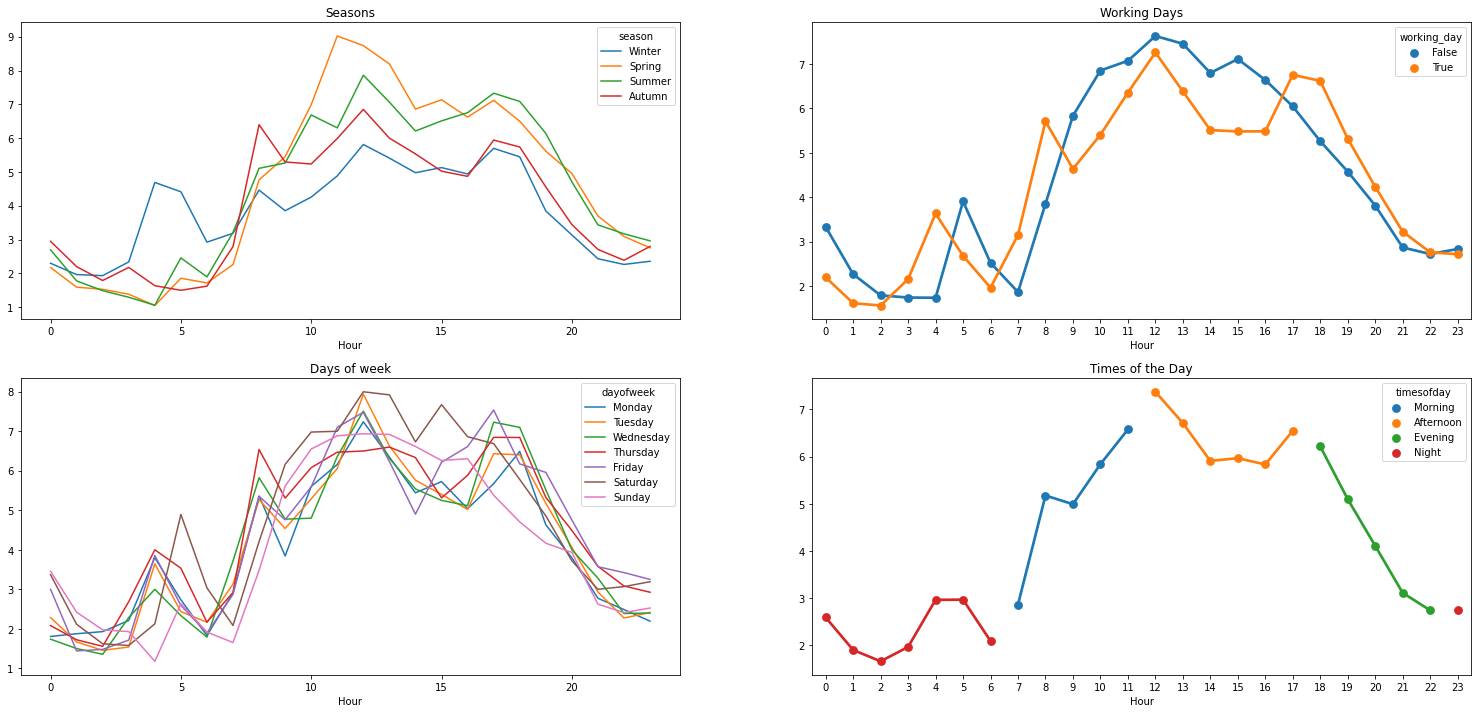

In [11]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(26, 12))

sns.lineplot(data=hourly_rentals, x='hour', y='count', hue='season', hue_order=['Winter','Spring','Summer','Autumn'], ax=ax[0][0], ci=None)
ax[0][0].set(xlabel='Hour', ylabel='', title='Seasons')

sns.lineplot(data=hourly_rentals, x='hour', y='count', hue='dayofweek', hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=ax[1][0], ci=None)
ax[1][0].set(xlabel='Hour', ylabel='', title='Days of week')

sns.pointplot(data=hourly_rentals, x="hour", y="count", hue="working_day", ax=ax[0][1], ci=None)
ax[0][1].set(xlabel='Hour', ylabel='', title='Working Days')

sns.pointplot(data=hourly_rentals, x='hour', y='count', hue='timesofday', hue_order=['Morning','Afternoon','Evening','Night'], ax=ax[1][1], ci=None)
ax[1][1].set(xlabel='Hour', ylabel='', title='Times of the Day')

plt.show()

When we plot the number o rentals on each hour of day, we notice that no discrepancy's found on different Seasons, Weekends/Holidays and even week days follow a similar pattern throughout the day.

In [36]:
all_data = pd.read_csv('../data/processed/all_data.csv')
all_data[["date"]] = all_data[["date"]].apply(pd.to_datetime)
all_data['month_year'] = pd.to_datetime(all_data['date']).dt.to_period('M')
df_month = all_data.groupby("month_year").agg({"bikeid": pd.Series.nunique})
df_month

,bikeid
month_year,
2021-03,94
2021-04,79
2021-05,78
2021-06,78
2021-07,77
2021-08,72
2021-09,75
2021-10,75
2021-11,73


## Monthly Data

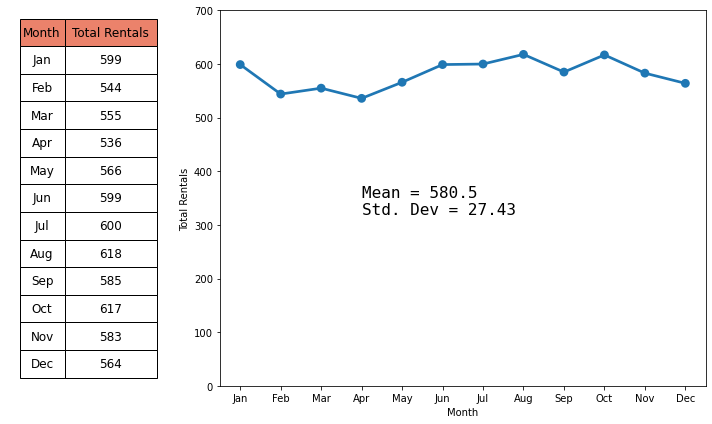

In [37]:
monthly_data = hourly_rentals.groupby('month')['count'].agg('count').reset_index(name='count')
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_data['monthly_data_str'] = monthly_data['month'].map(lambda d : month_map[d])
monthly_stats = f"Mean = {round(monthly_data['count'].mean(), 2)} \nStd. Dev = {round(monthly_data['count'].std(), 2)}"
monthly_data = monthly_data[['monthly_data_str', 'count']]
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(10,6), tight_layout=True)
ax[0].axis('off')
ax[0].axis('tight')
table = ax[0].table(cellText=monthly_data.values, colLabels=['Month','Total Rentals'], cellLoc='center', loc='center', colColours =["#eb826b"] * 2)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(monthly_data.columns)))) 
table.scale(3,2)
monthly_plot = sns.pointplot(x=monthly_data["monthly_data_str"], y=monthly_data["count"], ax=ax[1])
ax[1].set(ylim=(0,700), xlabel='Month', ylabel='Total Rentals')
monthly_plot.annotate(monthly_stats, xy=(3, 320), fontsize=16, fontfamily='monospace')
fig.tight_layout()
plt.show()

## Daily Data - Time Series

In [38]:
time_series_df = hourly_data.copy()
slice_daily_data = time_series_df[['date', 'holiday', 'dayofweek', 'working_day', 'season']]
time_series_df = time_series_df.groupby('date')['count'].agg('sum').reset_index(name='count')
time_series_df = pd.merge(time_series_df, slice_daily_data, on='date', how='left')
# time_series_df['datetime'] = pd.to_datetime(time_series_df.date) + pd.to_timedelta(time_series_df.hour, unit='h')
time_series_df['datetime'] = pd.to_datetime(time_series_df.date)
time_series_df.set_index('datetime', inplace=True)
time_series_df = time_series_df[~time_series_df.index.duplicated(keep='first')]
time_series_df.drop(time_series_df.tail(1).index,inplace=True)

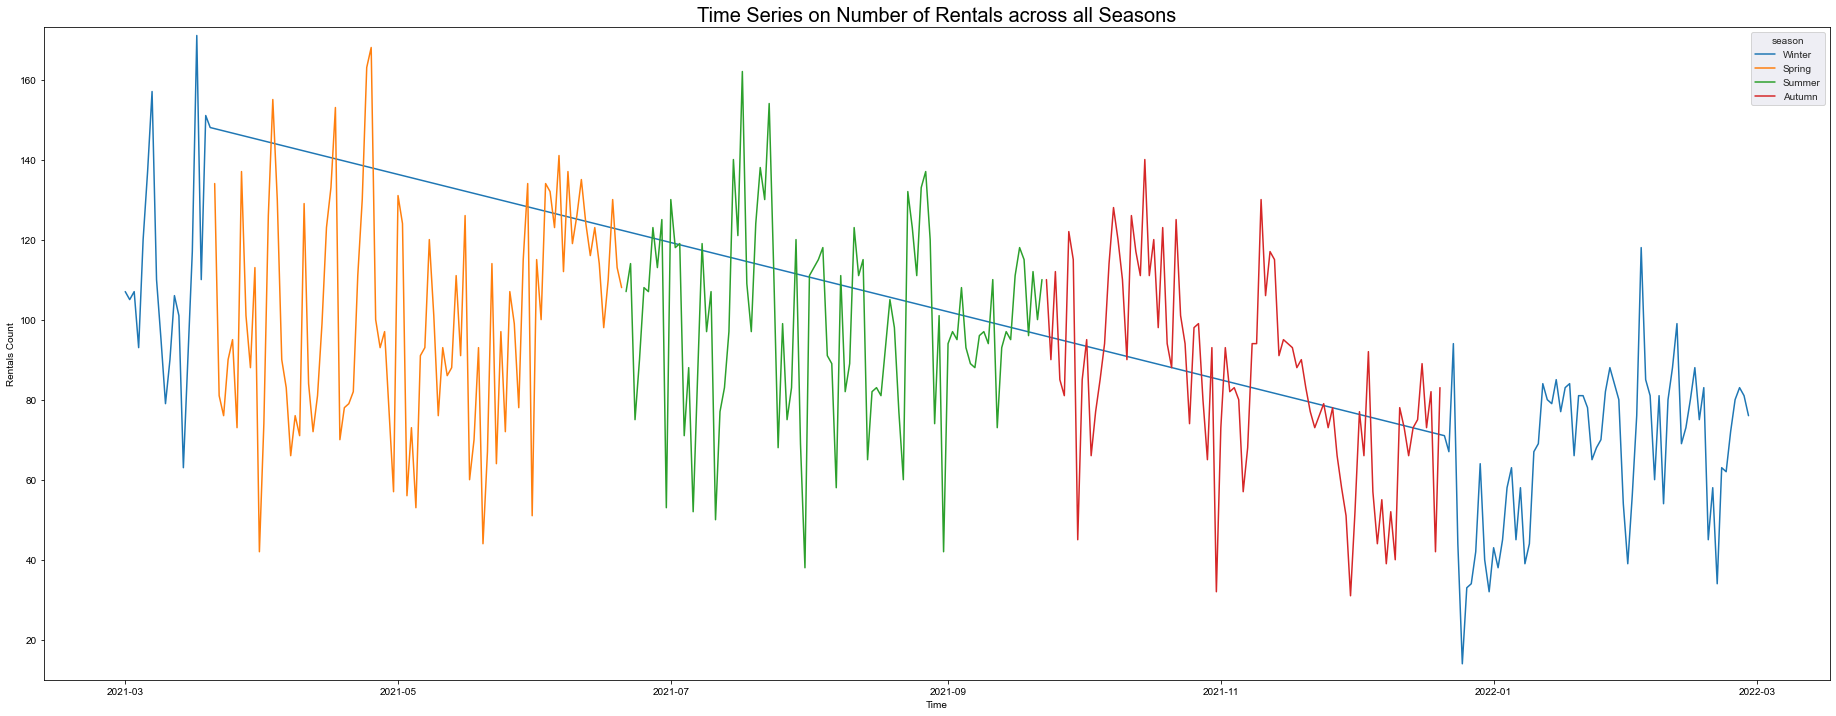

In [39]:
fig, ax = plt.subplots(figsize=(32, 12))
sns.set_style("darkgrid")
sns.lineplot(x=time_series_df.index, 
              y=time_series_df["count"], 
              hue=time_series_df["season"],
              hue_order=['Winter','Spring','Summer','Autumn'],
              ax=ax)
ax.set(xlabel='Time', ylabel='Rentals Count')
ax.set(ylim=(10,max(time_series_df["count"])+2))
ax.set_title(fontsize=20, label="Time Series on Number of Rentals across all Seasons")
plt.show()

## Poisson/NB vs Time series of count data

If a time series of count data is generated by a Poisson point process then event occurrences in successive time intervals are independent. Independence is a reasonable assumption when the underlying stochastic process for events, conditional on covariates, has no memory. Then there is no need for special time series models. For example, the number of deaths (or births) in a region may be uncorrelated over time. At the same time the population, which cumulates births and deaths, will be very highly correlated over time. 

The first step for time series count data is therefore to test for serial correlation.

In [ ]:
expr = \
     """ count ~ temp_r + wdsp + rhum + rain + holiday"""
y_train, X_train = dmatrices(expr, hourly_data, return_type = 'dataframe')
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial()).fit(maxiter=5000, method='nm', cov_type='HC3')
print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 2190
Model:                            GLM   Df Residuals:                     2184
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                            nm   Log-Likelihood:                -6308.6
Date:                Sun, 08 May 2022   Deviance:                       783.76
Time:                        13:32:47   Pearson chi2:                     630.
No. Iterations:                    56   Pseudo R-squ. (CS):            0.04568
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.6191      0.104     

In [ ]:
# print(f'AIC: {round(nb_training_results.aic,2)} \nBIC: {round(nb_training_results.bic,2)}')

### Durbin-Watson statistic

> https://www.statology.org/durbin-watson-test-python/

The Durbin-Watson statistic will always have a value ranging between 0 and 4. A value of 2.0 indicates there is no autocorrelation detected in the sample. Values from 0 to less than 2 point to positive autocorrelation and values from 2 to 4 means negative autocorrelation.

In [ ]:
# The response residuals are defined as endog - fittedvalues

# The hypotheses followed for the Durbin Watson statistic:
# H(0) = First-order autocorrelation does not exist.
# H(1) = First-order autocorrelation exists.

print(f'Durbin-Watson test for serial correlation: {round(durbin_watson(nb_training_results.resid_response),2)}')

Durbin-Watson test for serial correlation: 1.4


**Possible positive autocorrelation**

A rule of thumb is that DW test statistic values in the range of 1.5 to 2.5 are relatively normal. Values outside this range could, however, be a cause for concern. Field(2009) suggests that values under 1 or more than 3 are a definite cause for concern.

>Field, A. (2009). Discovering Statistics Using SPSS, 3rd Edition (Introducing Statistical Methods) (3rd ed.). SAGE Publications Ltd.

In [50]:
houlyTM = hourly_data[['date','hour','count']].copy()
# houlyTM = hourly_rentals[['date','hour','count']].copy()
houlyTM['datetime'] = pd.to_datetime(houlyTM.date) + pd.to_timedelta(houlyTM.hour, unit='h')
houlyTM.set_index('datetime', inplace=True)
houlyTM.drop(houlyTM.tail(25).index,inplace=True)

### Residual Autocorrelation and Partial autocorrelation

Autocorrelation occurs when the residuals are not independent of each other.

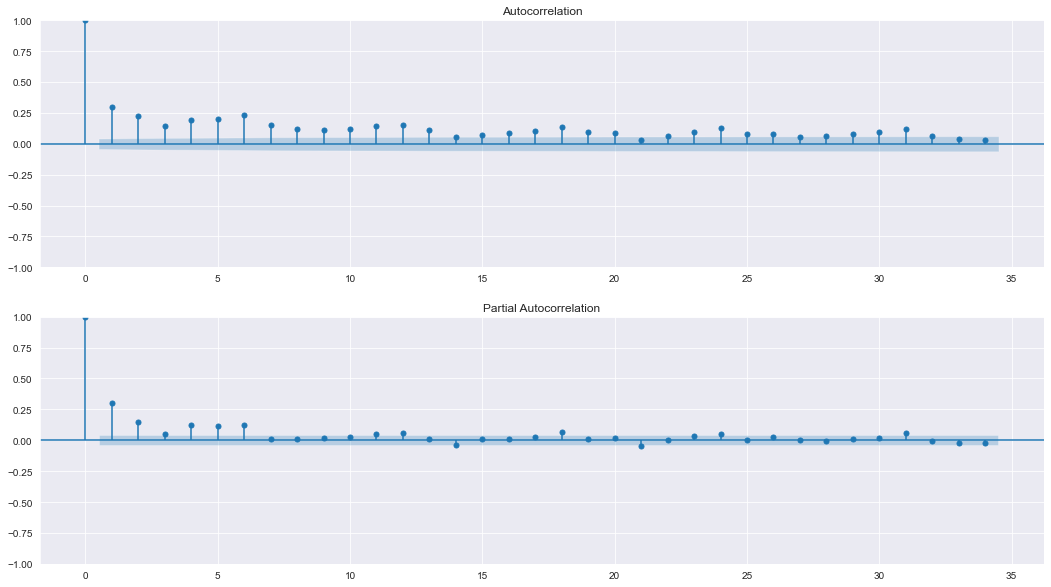

In [51]:
fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
plot_acf(nb_training_results.resid_response, ax=ax0)
plot_pacf(nb_training_results.resid_response, ax=ax1)
plt.show()

How to Handle Autocorrelation

If you reject the null hypothesis and conclude that autocorrelation is present in the residuals, then you have a few different options to correct this problem if you deem it to be serious enough:

1. For positive serial correlation, consider adding lags of the dependent and/or independent variable to the model.

2. For negative serial correlation, check to make sure that none of your variables are overdifferenced.

3. For seasonal correlation, consider adding seasonal dummy variables to the model.

***

<div class="alert alert-block alert-info">
<b>Time series modeling</b> allows us to replicate every element of the process by decomposing the mathematical process into a combination of <u>signals</u> (e.g. growth in demand, seasonal variability, etc) and <u>noise</u> (random probabilistic processes), withou necessarily knowing the underlying causes for each.
</div>

> https://medium.com/swlh/multi-linear-regression-using-python-44bd0d10082d

### Considerations
- Count has a fixed range due to limitation on bikes available. (e.g. we cannot have more than 30 rentals if Moby Bikes only has 30 bikes available and to a new rental begins the bike needs to become available (current rental finished))
- The duration of rentals is relevant and directly impacts the number of rentals per day.
- Because we have a limited range of occurence on our target feature, decisions trees can be applied as they can only predict within the training range.
- Hourly data requires an approach which can count with autocorrelation. Temperature, Humidity and Wind Speed are not randomly throughout the hours. If one hour we have a temperature of 25C, on the next hour is very likely that temperature will be closed to that. (time series?)
- Capturing the relationship on these variables as continuous can be hard for machine learning algorithms as the range is to high. Temperature of 13.4C and 13.9C or 13C and 15C, are practically the same if you think about deciding whether to go bicicling or not. The same rule applies for humidity and wind speed. Transforming these variables into categoricals can provide more relevance to the algorithms.

```python
# Stacking Random Forest and GBM
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)
# taking weighted average of output from two models
y_pred = np.round(.20*rf_pred + .80*gbm_pred)
```
- Consider transforming all features into categories or merge all into one (e.g. good weather = high temperature + weak wind speed + light or no rain). 
```python
df['ideal'] = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
```

- If we take the log(count), RMSLE can be computed with:
```python
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)
```

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini